In [1]:
import pandas as pd
import os

# Chemin vers ton fichier
file_path = '/faststorage/project/DEIC-SDU-L2-22/llmproject/movielens/ML972K.csv'

# Charger le CSV
df = pd.read_csv(file_path)

# Vérification rapide
print(f"Shape du dataset : {df.shape}")
df.head()

Shape du dataset : (972998, 9)


,UserID,MovieID,Rating,Timestamp,Gender,Occupation,Title,Genres,AgeGroup
0,2,1357,5,978298709,Male,self-employed,Shine (1996),"Drama, Romance",56+
1,2,3068,4,978299000,Male,self-employed,"Verdict, The (1982)",Drama,56+
2,2,1537,4,978299620,Male,self-employed,Shall We Dance? (Shall We Dansu?) (1996),Comedy,56+
3,2,647,3,978299351,Male,self-employed,Courage Under Fire (1996),"Drama, War",56+
4,2,2194,4,978299297,Male,self-employed,"Untouchables, The (1987)","Action, Crime, Drama",56+


In [2]:
!nvidia-smi

Tue Oct 28 21:05:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    Off |   00000000:02:00.0 Off |                    0 |
| N/A   29C    P8             32W /  350W |       1MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import pandas as pd

# Utiliser le dataset final filtré
df_sampled = df

# Initialiser les listes pour chaque split
train_list, test_list = [], []

# Découpage par utilisateur
for user, group in df_sampled.groupby('UserID'):
    group = group.sample(frac=1, random_state=42).reset_index(drop=True)

    n = len(group)
    n_train = max(int(n * 0.8), 1)  # au moins 1 interaction pour train
    n_test  = n - n_train           # le reste pour test

    # Ajouter les tranches à chaque liste
    train_list.append(group.iloc[:n_train])
    test_list.append(group.iloc[n_train:])

# Concaténer les listes pour obtenir les DataFrames finaux
train_df = pd.concat(train_list).reset_index(drop=True)
test_df  = pd.concat(test_list).reset_index(drop=True)

# Affichage des tailles
print("Train size :", train_df.shape)
print("Test size  :", test_df.shape)

Train size : (776076, 9)
Test size  : (196922, 9)


In [4]:
import pandas as pd
from tqdm import tqdm

def generate_train_history_minimal(df, history_size=5):
    """
    Génère l'historique structuré minimaliste pour chaque utilisateur
    en prenant seulement le dernier segment de `history_size` films.
    Gardé pour Alpaca : UserID, AgeGroup, history (Genres+Rating), TargetMovieID, TargetGenres
    """
    rows = []

    for user_id, group in tqdm(df.groupby('UserID', sort=False), desc="Processing users"):
        age_group = str(group['AgeGroup'].iloc[0])

        # Trier les films par timestamp
        group = group.sort_values('Timestamp')

        # Supprimer les doublons
        group = group.drop_duplicates(subset='MovieID')

        # Supprimer les genres inconnus
        group = group[group['Genres'].notna() & (group['Genres'] != 'unknown')]

        # Séparer historique et cible
        if len(group) <= history_size:
            history_rows = group.iloc[:-1]  # tout sauf le dernier film
            target_row = group.iloc[-1]     # dernier film comme cible
        else:
            history_rows = group.iloc[-history_size:-1]  # dernier segment comme historique
            target_row = group.iloc[-1]                  # dernier film comme cible

        if len(history_rows) == 0:
            continue

        # Construire l'historique minimal (Genres et Rating seulement)
        history_list = [
            f"({row['Genres']}) rated {row['Rating']}" for _, row in history_rows.iterrows()
        ]
        history_text = "; ".join(history_list)

        # Ajouter au dataset
        rows.append({
            "UserID": user_id,
            "AgeGroup": age_group,
            "History": history_text,
            "TargetMovieID": target_row['MovieID'],
            "TargetGenres": target_row['Genres'],
            "TargetRating": target_row['Rating']
        })

    return pd.DataFrame(rows)

# Générer et sauvegarder
train_history_minimal = generate_train_history_minimal(train_df, history_size=5)
train_history_minimal.to_csv(
    '/faststorage/project/DEIC-SDU-L2-22/llmproject/movielens/history/train_user_historyMLv2.csv',
    index=False
)

print(train_history_minimal.head())

Processing users: 100%|███████████████████████████████████████████████████████████| 5818/5818 [00:04<00:00, 1312.18it/s]

   UserID AgeGroup                                            History  \
0       2      56+  (Action, Drama, Thriller) rated 3; (Action, Th...   
1       3    25-34  (Animation, Children's, Comedy) rated 5; (Come...   
2       4    45-49  (Action, Sci-Fi) rated 4; (Action, Drama) rate...   
3       5    25-34  (Comedy, Romance) rated 4; (Comedy, Drama) rat...   
4       6    50-55  (Comedy, Romance) rated 5; (Action) rated 4; (...   

   TargetMovieID      TargetGenres  TargetRating  
0           1687  Action, Thriller             3  
1           3868            Comedy             3  
2           1036  Action, Thriller             4  
3            288  Action, Thriller             2  
4           1569   Comedy, Romance             4  


In [5]:
import pandas as pd
from tqdm import tqdm

def generate_test_history_minimal(df, history_size=5):
    """
    Génère l'historique structuré minimaliste pour chaque utilisateur dans le test
    en prenant seulement le dernier segment de `history_size` films.
    Historique minimal : UserID, AgeGroup, Genres+Rating, TargetMovieID, TargetGenres, TargetRating
    """
    rows = []

    for user_id, group in tqdm(df.groupby('UserID', sort=False), desc="Processing test users"):
        age_group = str(group['AgeGroup'].iloc[0])

        # Trier par Timestamp
        group = group.sort_values('Timestamp')

        # Supprimer doublons et genres inconnus
        group = group.drop_duplicates(subset='MovieID')
        group = group[group['Genres'].notna() & (group['Genres'] != 'unknown')]

        # Ignorer si pas assez de films
        if len(group) < history_size + 1:
            continue

        # Prendre le dernier segment
        history_rows = group.iloc[-(history_size + 1):-1]  # derniers 'history_size' films
        target_row = group.iloc[-1]  # dernier film comme cible

        # Construire l'historique minimal (Genres et Rating seulement)
        history_list = [
            f"({row['Genres']}) rated {row['Rating']}" for _, row in history_rows.iterrows()
        ]
        history_text = "; ".join(history_list)

        rows.append({
            "UserID": user_id,
            "AgeGroup": age_group,
            "History": history_text,
            "TargetMovieID": target_row['MovieID'],
            "TargetGenres": target_row['Genres'],
            "TargetRating": target_row['Rating']
        })

    return pd.DataFrame(rows)

# Générer et sauvegarder pour le test
test_history_minimal = generate_test_history_minimal(test_df, history_size=5)
test_history_minimal.to_csv(
    '/faststorage/project/DEIC-SDU-L2-22/llmproject/movielens/history/test_user_historyMLv2.csv',
    index=False
)

print(test_history_minimal.head())


Processing test users: 100%|██████████████████████████████████████████████████████| 5818/5818 [00:04<00:00, 1345.65it/s]


   UserID AgeGroup                                            History  \
0       2      56+  (Action, Adventure, Comedy, Romance) rated 5; ...   
1       3    25-34  (Action, Adventure, Horror, Thriller) rated 2;...   
2       5    25-34  (Drama) rated 2; (Drama) rated 4; (Drama) rate...   
3       6    50-55  (Comedy, Romance) rated 4; (Comedy, Romance) r...   
4       7    35-44  (Action, Drama, War) rated 4; (Action, Sci-Fi,...   

   TargetMovieID                                     TargetGenres  \
0            434                         Action, Adventure, Crime   
1           2081  Animation, Children's, Comedy, Musical, Romance   
2             52                                           Comedy   
3            597                                  Comedy, Romance   
4           3107                                    Action, Drama   

   TargetRating  
0             2  
1             4  
2             2  
3             5  
4             3  


In [6]:
# Utilisateurs uniques dans chaque split
train_users = set(train_df['UserID'].unique())
test_users  = set(test_df['UserID'].unique())

# Vérifier si des utilisateurs de test ne sont pas présents dans train
test_missing_in_train = test_users - train_users

print("\nNombre d'utilisateurs dans test absents du train :", len(test_missing_in_train))
if len(test_missing_in_train) > 0:
    print("Liste :", sorted(test_missing_in_train))


Nombre d'utilisateurs dans test absents du train : 0


In [ ]:
from huggingface_hub import login
login("---")

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "mistralai/Mistral-7B-Instruct-v0.1"

# Configuration pour chargement en 4-bit avec bitsandbytes
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

# Tokenizer (pas besoin de trust_remote_code ici)
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token  # Important pour les modèles causaux

# Modèle (sans trust_remote_code)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

2025-10-28 21:05:37.723558: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-28 21:05:37.781325: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-28 21:05:39.987180: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/zahra/jupyter-env/lib64/python3.9/site-packages/networkx/utils

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
prompt_template_movielens = """### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID={userId}, AgeGroup={age}
User Movie History: {history_str}
Target Movie: ID={movieId}, Genres="{Genres}"

### Response:
"""

In [10]:
# Fusionner les historiques avec les datasets train et test
train_df = train_df.merge(
    train_history_minimal,
    left_on="UserID",
    right_on="UserID",
    how="left"
)

test_df = test_df.merge(
    train_history_minimal,
    left_on="UserID",
    right_on="UserID",
    how="left"
)

# Renommer la colonne pour correspondre au pipeline
train_df = train_df.rename(columns={"History": "history_str"})
test_df = test_df.rename(columns={"History": "history_str"})

In [11]:
train_df = train_df.rename(columns={'AgeGroup_x': 'AgeGroup'})
train_df = train_df.drop(columns=['AgeGroup_y'], errors='ignore')

test_df = test_df.rename(columns={'AgeGroup_x': 'AgeGroup'})
test_df = test_df.drop(columns=['AgeGroup_y'], errors='ignore') 

In [12]:
print(train_df['history_str'].isna().sum())
print(test_df['history_str'].isna().sum())

0
0


In [13]:
def format_prompt_movies(example):
    # Récupérer l'historique de l'utilisateur
    history_str = example.get('history_str', 'No history available')

    # Générer le prompt adapté à Movielens
    prompt = prompt_template_movielens.format(
        userId=example['UserID'],
        age=example['AgeGroup'],
        movieId=example['MovieID'],
        Genres=example.get('Genres', ''),
        history_str=history_str
    ).rstrip()

    # La note réelle
    label = str(int(example['Rating']))

    return {"prompt": prompt, "completion": label}


In [14]:
# Appliquer format_prompt_movies à tous les datasets
train_dataset = train_df.apply(format_prompt_movies, axis=1)
test_dataset = test_df.apply(format_prompt_movies, axis=1)

# Convertir en DataFrames
train_formatted = pd.DataFrame(list(train_dataset))
test_formatted = pd.DataFrame(list(test_dataset))

In [15]:
train_df.columns

Index(['UserID', 'MovieID', 'Rating', 'Timestamp', 'Gender', 'Occupation',
       'Title', 'Genres', 'AgeGroup', 'history_str', 'TargetMovieID',
       'TargetGenres', 'TargetRating'],
      dtype='object')

In [16]:
print(train_dataset[0].keys())

dict_keys(['prompt', 'completion'])


In [17]:
from datasets import Dataset, DatasetDict

train_ds = Dataset.from_pandas(train_formatted)
test_ds = Dataset.from_pandas(test_formatted)

dataset = DatasetDict({
    "train": train_ds,
    "test": test_ds
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 776076
    })
    test: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 196922
    })
})


In [18]:
test_formatted.to_json("/faststorage/project/DEIC-SDU-L2-22/llmproject/movielens/history/v2/test_formattedML972Khisv2.json", orient="records", lines=True)

In [19]:
for i in range(5):
    example = dataset['train'][i]
    print("Prompt :\n", example['prompt'])
    print("Completion :\n", example['completion'])
    print("-"*50)

Prompt :
 ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=515, Genres="Drama"

### Response:
Completion :
 5
--------------------------------------------------
Prompt :
 ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Tar

In [20]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
model = prepare_model_for_kbit_training(model)
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj"]
)
model = get_peft_model(model, peft_config)

In [21]:
import importlib
import trl

In [22]:
from trl import SFTConfig, SFTTrainer

# Configuration SFT
sft_config = SFTConfig(
    output_dir="/faststorage/project/DEIC-SDU-L2-22/llmproject/movielens/history/MovieLens_fine_tuned_972Khisv2.2",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=8,
    learning_rate=2e-5,
    logging_steps=220,
    num_train_epochs=2,
    save_strategy="epoch",
    eval_strategy="no",
    bf16=True,
    fp16=False,
    optim="paged_adamw_32bit",
    max_grad_norm=1.0,
    warmup_ratio=0.03,
    lr_scheduler_type="cosine",
    packing=False,
    dataset_text_field="prompt",
    logging_dir="./logs",
    report_to=[],
    completion_only_loss=True,
)

# Initialisation du Trainer
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=None,
    peft_config=peft_config,
    args=sft_config
)

/home/zahra/jupyter-env/lib64/python3.9/site-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Adding EOS to train dataset:   0%|          | 0/776076 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/776076 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/776076 [00:00<?, ? examples/s]

In [ ]:
trainer.train()
trainer.model.save_pretrained("/faststorage/project/DEIC-SDU-L2-22/llmproject/movielens/history/MovieLens_fine_tuned_972Khisv2.2")
tokenizer.save_pretrained("/faststorage/project/DEIC-SDU-L2-22/llmproject/movielens/history/MovieLens_fine_tuned_972Khisv2.2")

Step,Training Loss
220,2.025700
440,0.708700
660,0.710600
880,0.772800


In [4]:
 import torch
 from transformers import AutoModelForCausalLM, AutoTokenizer

 tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
 mistral = AutoModelForCausalLM.from_pretrained(
     "mistralai/Mistral-7B-Instruct-v0.1",
     device_map="auto",
     torch_dtype="auto",
     # quantization_config=bnb_config,
     trust_remote_code=True
 )
 from peft import PeftModel
 LORA_PATH = "/faststorage/project/DEIC-SDU-L2-22/llmproject/movielens/history/MovieLens_fine_tuned_972Khisv2.2"
 model = PeftModel.from_pretrained(mistral, LORA_PATH, strict=False, ignore_mismatched_size = True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
 import pandas as pd

 # Charger le JSON depuis Google Drive
 file_path = "/faststorage/project/DEIC-SDU-L2-22/llmproject/movielens/history/v2/test_formattedML972Khisv2.json"
 test_formatted = pd.read_json(file_path, orient="records", lines=True)

 # Vérification rapide
 print(test_formatted.head())
 print(test_formatted.shape)

                                              prompt  completion
0  ### Instruction:\nPredict the rating (an integ...           4
1  ### Instruction:\nPredict the rating (an integ...           3
2  ### Instruction:\nPredict the rating (an integ...           4
3  ### Instruction:\nPredict the rating (an integ...           4
4  ### Instruction:\nPredict the rating (an integ...           5
(196922, 2)


In [6]:
#Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from transformers import GenerationConfig

#  Mettre le modèle en mode évaluation
model.eval()

generation_config = GenerationConfig(
    max_new_tokens=10,
    do_sample=False,
    repetition_penalty=1.0,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id
)

In [7]:
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

In [5]:
import re

def clean_prediction(pred_text, fallback_value=None):
    if not pred_text:
        return fallback_value

    # Nettoyer texte
    pred_text = pred_text.strip().replace("\n", " ")
    pred_text = re.sub(r"[^a-zA-Z0-9\s]", "", pred_text.lower())

    # Chercher chiffre 1-5
    match = re.search(r"(?:### )?Response[:\s]*(?:is\s*)?([1-5])\b", pred_text, re.IGNORECASE)
    if match:
        return int(match.group(1))

    # Chercher nombres en lettres (FR/EN)
    word_to_digit = {
        "un":1, "deux":2, "trois":3, "quatre":4, "cinq":5,
        "one":1, "two":2, "three":3, "four":4, "five":5
    }
    for word, digit in word_to_digit.items():
        if re.search(rf"\b{word}\b", pred_text):
            return digit

    # fallback
    return fallback_value

In [6]:
import json
from tqdm import tqdm
import re
import torch

def clean_prediction(pred_text, fallback_value=-1):
    if not pred_text:
        return fallback_value

    # Nettoyer texte
    pred_text = pred_text.strip().replace("\n", " ")
    pred_text = re.sub(r"[^a-zA-Z0-9\s]", "", pred_text.lower())

    # Chercher chiffre 1-5
    match = re.search(r"(?:### )?Response[:\s]*(?:is\s*)?([1-5])\b", pred_text, re.IGNORECASE)
    if match:
        return int(match.group(1))

    # Chercher nombres en lettres
    word_to_digit = {
        "un":1, "deux":2, "trois":3, "quatre":4, "cinq":5,
        "one":1, "two":2, "three":3, "four":4, "five":5
    }
    for word, digit in word_to_digit.items():
        if word in pred_text:
            return digit

    return fallback_value

batch_size = 40
test_predictions = []
true_labels = []

max_display = 70
displayed = 0
max_retries = 3

for start_idx in tqdm(range(0, len(test_formatted), batch_size), desc="Inference batches"):
    batch = test_formatted.iloc[start_idx:start_idx+batch_size]
    prompts = batch['prompt'].tolist()

    # Tokenisation + envoi sur GPU
    inputs = {k: v.to(model.device) for k, v in tokenizer(prompts, return_tensors="pt", truncation=True, padding=True, max_length=1024).items()}

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            generation_config=generation_config
        )

    for i, output in enumerate(outputs):
        prediction = tokenizer.decode(output, skip_special_tokens=True).strip()
        pred_note = clean_prediction(prediction)

        retries = 0
        # Retry si valeur invalide
        while pred_note not in [1,2,3,4,5] and retries < max_retries:
            retries += 1
            with torch.no_grad():
                new_output = model.generate(
                    input_ids=inputs['input_ids'][i].unsqueeze(0),
                    attention_mask=inputs['attention_mask'][i].unsqueeze(0),
                    generation_config=generation_config
                )
            prediction = tokenizer.decode(new_output[0], skip_special_tokens=True).strip()
            pred_note = clean_prediction(prediction)

        if displayed < max_display:
            print(f"Prompt:\n{prompts[i]}")
            print(f"Prediction brute: {prediction}")
            print(f"Note extraite: {pred_note}\n")
            displayed += 1

        test_predictions.append(pred_note)
        true_labels.append(int(batch.iloc[i]['completion']))

results = [
    {
        "prompt": test_formatted.iloc[i]['prompt'],
        "true_label": true_labels[i],
        "predicted_label": test_predictions[i]
    }
    for i in range(len(test_predictions))
]

output_path = "./results_predictions_ml_history_ml2.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

print(f"\n Résultats sauvegardés dans '{output_path}' ({len(results)} entrées)")

Inference batches:   0%|                                                                                  | 0/4924 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1442, Genres="Drama"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1442, Genres="Drama"

### Response:
Note extra

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=3255, Genres="Comedy, Drama"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=3255, Genres="Comedy, Drama"

### Resp

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1962, Genres="Drama"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1962, Genres="Drama"

### Response:
Note extra

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=2858, Genres="Comedy, Drama"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=2858, Genres="Comedy, Drama"

### Resp

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1537, Genres="Comedy"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1537, Genres="Comedy"

### Response:
Note ext

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1096, Genres="Drama"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1096, Genres="Drama"

### Response:
Note extra

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1597, Genres="Action, Mystery, Romance, Thriller"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1597, Genres="Act

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1196, Genres="Action, Adventure, Drama, Sci-Fi, War"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1196, Genres="

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=2571, Genres="Action, Sci-Fi, Thriller"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=2571, Genres="Action, Sci-F

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1084, Genres="Crime, Drama"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1084, Genres="Crime, Drama"

### Respon

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1527, Genres="Action, Sci-Fi"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1527, Genres="Action, Sci-Fi"

### Re

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1124, Genres="Drama"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=1124, Genres="Drama"

### Response:
Note extra

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=457, Genres="Action, Thriller"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=2, AgeGroup=56+
User Movie History: (Action, Drama, Thriller) rated 3; (Action, Thriller) rated 2; (Action, Adventure, Sci-Fi, Thriller) rated 4; (Action, Adventure, Sci-Fi, Thriller) rated 3
Target Movie: ID=457, Genres="Action, Thriller"

### 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=3, AgeGroup=25-34
User Movie History: (Animation, Children's, Comedy) rated 5; (Comedy) rated 2; (Comedy) rated 5; (Comedy) rated 4
Target Movie: ID=1079, Genres="Comedy"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=3, AgeGroup=25-34
User Movie History: (Animation, Children's, Comedy) rated 5; (Comedy) rated 2; (Comedy) rated 5; (Comedy) rated 4
Target Movie: ID=1079, Genres="Comedy"

### Response:
Note extraite: -1

Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=3, AgeGroup=25-34
User Movie History: (Animation, Children's, Comedy) rated 5; (Comedy) rated 2; (Comedy) rated 5; (Comedy) rated 4
Target Movie: ID=3619, Genres="Comedy"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=3, AgeGroup=25-34
User Movie History: (Animation, Children's, Comedy) rated 5; (Comedy) rated 2; (Comedy) rated 5; (Comedy) rated 4
Target Movie: ID=3619, Genres="Comedy"

### Response:
Note extraite: -1

Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=3, AgeGroup=25-34
User Movie History: (Animation, Children's, Comedy) rated 5; (Comedy) rated 2; (Comedy) rated 5; (Comedy) rated 4
Target Movie: ID=1210, Genres="Action, Adventure, Romance, Sci-Fi, War"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=3, AgeGroup=25-34
User Movie History: (Animation, Children's, Comedy) rated 5; (Comedy) rated 2; (Comedy) rated 5; (Comedy) rated 4
Target Movie: ID=1210, Genres="Action, Adventure, Romance, Sci-Fi, War"

### Response:
Note extraite: -1

Prompt:
### Instruction:
Predict the rating

Inference batches:   0%|                                                                        | 1/4924 [00:05<8:08:43,  5.96s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=4, AgeGroup=45-49
User Movie History: (Action, Sci-Fi) rated 4; (Action, Drama) rated 4; (Action, Sci-Fi, Thriller) rated 5; (Action, Western) rated 4
Target Movie: ID=480, Genres="Action, Adventure, Sci-Fi"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=4, AgeGroup=45-49
User Movie History: (Action, Sci-Fi) rated 4; (Action, Drama) rated 4; (Action, Sci-Fi, Thriller) rated 5; (Action, Western) rated 4
Target Movie: ID=480, Genres="Action, Adventure, Sci-Fi"

### Response:
Note extraite: -1

Prompt:
### Instruction:
Predict th

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=4, AgeGroup=45-49
User Movie History: (Action, Sci-Fi) rated 4; (Action, Drama) rated 4; (Action, Sci-Fi, Thriller) rated 5; (Action, Western) rated 4
Target Movie: ID=2947, Genres="Action"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=4, AgeGroup=45-49
User Movie History: (Action, Sci-Fi) rated 4; (Action, Drama) rated 4; (Action, Sci-Fi, Thriller) rated 5; (Action, Western) rated 4
Target Movie: ID=2947, Genres="Action"

### Response:
Note extraite: -1

Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) fo

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=265, Genres="Drama, Romance"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=265, Genres="Drama, Romance"

### Response:
Note extraite: -1

Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's p

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=1747, Genres="Comedy, Drama"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=1747, Genres="Comedy, Drama"

### Response:
Note extraite: -1

Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's p

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=356, Genres="Comedy, Romance, War"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=356, Genres="Comedy, Romance, War"

### Response:
Note extraite: -1

Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=1923, Genres="Comedy"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=1923, Genres="Comedy"

### Response:
Note extraite: -1

Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and mov

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=2683, Genres="Comedy"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=2683, Genres="Comedy"

### Response:
Note extraite: -1

Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and mov

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=3499, Genres="Horror"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=3499, Genres="Horror"

### Response:
Note extraite: -1

Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and mov

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=1192, Genres="Documentary"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=1192, Genres="Documentary"

### Response:
Note extraite: -1

Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profi

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=2890, Genres="Drama, War"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=2890, Genres="Drama, War"

### Response:
Note extraite: -1

Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=1643, Genres="Drama, Romance"

### Response:
Prediction brute: ### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's profile and movie history. Focus only on the user's preferences and movie genres. Return only the rating.

### Input:
User Profile: ID=5, AgeGroup=25-34
User Movie History: (Comedy, Romance) rated 4; (Comedy, Drama) rated 3; (Drama) rated 2; (Comedy) rated 3
Target Movie: ID=1643, Genres="Drama, Romance"

### Response:
Note extraite: -1

Prompt:
### Instruction:
Predict the rating (an integer from 1 to 5) for the target movie based on the user's

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

KeyboardInterrupt: 

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse_test = np.sqrt(mean_squared_error(true_labels, test_predictions))
mae_test = mean_absolute_error(true_labels, test_predictions)

print(f"RMSE test : {rmse_test:.4f}")
print(f"MAE test  : {mae_test:.4f}")

RMSE test : 1.1178
MAE test  : 0.8178


In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Charger le fichier
file_path = "/faststorage/project/DEIC-SDU-L2-22/llmproject/movielens/history/v2/results_predictions_ml_history_ml2.json"
df = pd.read_json(file_path)

# Vérifier les colonnes
print(df.columns)

# Extraire les labels
true_labels = df["true_label"].values
test_predictions = df["predicted_label"].values

# Calcul des métriques
rmse_test = np.sqrt(mean_squared_error(true_labels, test_predictions))
mae_test = mean_absolute_error(true_labels, test_predictions)

print(f"RMSE test : {rmse_test:.4f}")
print(f"MAE test  : {mae_test:.4f}")


Index(['prompt', 'true_label', 'predicted_label'], dtype='object')
RMSE test : 1.1887
MAE test  : 0.8691


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Charger le fichier
file_path = "/faststorage/project/DEIC-SDU-L2-22/llmproject/movielens/history/v2/results_predictions_ml_history_ml2.json"
df = pd.read_json(file_path)

# Vérifier les colonnes
print(df.columns)

# Extraire les labels
true_labels = df["true_label"].values
test_predictions = df["predicted_label"].values

# Calcul des métriques
rmse_test = np.sqrt(mean_squared_error(true_labels, test_predictions))
mae_test = mean_absolute_error(true_labels, test_predictions)

print(f"RMSE test : {rmse_test:.4f}")
print(f"MAE test  : {mae_test:.4f}")


Index(['prompt', 'true_label', 'predicted_label'], dtype='object')
RMSE test : 1.1887
MAE test  : 0.8691


In [9]:
import json

# Charger les résultats
with open("/faststorage/project/DEIC-SDU-L2-22/llmproject/movielens/history/v2/results_predictions_ml_history_ml2.json", "r", encoding="utf-8") as f:
    results = json.load(f)

# Extraire vraies étiquettes et prédictions
true_labels = [item["true_label"] for item in results]
test_predictions = [item["predicted_label"] for item in results]

# Transformer en binaire pour AUC
binary_test_labels = [1 if label >= 4 else 0 for label in true_labels]
binary_scores = [(pred - 1)/4 if pred is not None else 0.5 for pred in test_predictions]

# Calcul AUC
from sklearn.metrics import roc_auc_score
auc_llm = roc_auc_score(binary_test_labels, binary_scores)
print(f"AUC test LLM : {auc_llm:.4f}")


AUC test LLM : 0.5000


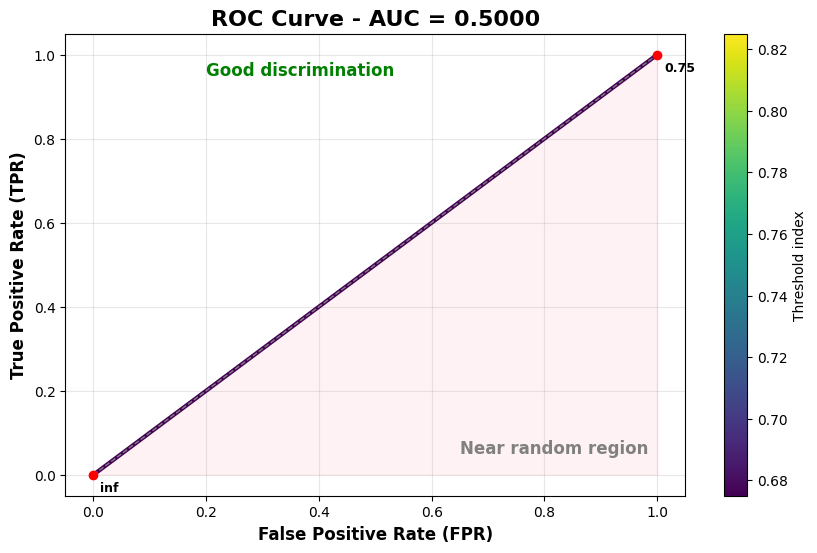

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from matplotlib.cm import ScalarMappable

# --- Supposons que binary_test_labels et binary_scores existent déjà ---
# binary_test_labels : vraie classe binaire (0 ou 1)
# binary_scores : score de prédiction continu entre 0 et 1

# Calculer FPR, TPR et thresholds
fpr, tpr, thresholds = roc_curve(binary_test_labels, binary_scores)
roc_auc = auc(fpr, tpr)

# Créer figure et axes
fig, ax = plt.subplots(figsize=(10,6))

# Dégradé de couleurs pour la courbe
colors = plt.cm.viridis(np.linspace(0, 1, len(thresholds)-1))
for i in range(len(fpr)-1):
    ax.plot(fpr[i:i+2], tpr[i:i+2], color=colors[i], linewidth=3)

# Remplir la zone sous la courbe avec couleur rose pastel
ax.fill_between(fpr, tpr, alpha=0.2, color='pink')

# Ligne diagonale de référence (hasard)
ax.plot([0,1], [0,1], color='gray', linestyle='--', linewidth=1)

# Ajouter points et annotations de seuils (max 10 points pour lisibilité)
step = max(1, len(thresholds)//10)
for i in range(0, len(thresholds), step):
    ax.plot(fpr[i], tpr[i], 'o', color='red', markersize=6)
    ax.annotate(f'{thresholds[i]:.2f}', (fpr[i], tpr[i]),
                textcoords="offset points", xytext=(5,-12),
                fontsize=9, color='black', fontweight='bold')

# Ajouter textes explicatifs éloignés de la courbe
ax.text(0.65, 0.05, 'Near random region', fontsize=12, color='gray', fontweight='bold')
ax.text(0.2, 0.95, 'Good discrimination', fontsize=12, color='green', fontweight='bold')

# Titres et axes (AUC avec 4 décimales)
ax.set_xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate (TPR)', fontsize=12, fontweight='bold')
ax.set_title(f'ROC Curve - AUC = {roc_auc:.4f}', fontsize=16, fontweight='bold')
ax.grid(alpha=0.3)

# Colorbar pour le dégradé
sm = ScalarMappable(cmap='viridis')
sm.set_array(thresholds)
plt.colorbar(sm, ax=ax, label='Threshold index')

plt.show()


In [11]:
from sklearn.model_selection import train_test_split

# Split directement sur le DataFrame déjà formaté
calibration_formatted, real_test_formatted = train_test_split(
    test_formatted, test_size=0.2, random_state=42
)

# Vérifier
print(calibration_formatted.head())
print(real_test_formatted.head())

                                                   prompt  completion
83195   ### Instruction:\nPredict the rating (an integ...           4
65046   ### Instruction:\nPredict the rating (an integ...           3
103829  ### Instruction:\nPredict the rating (an integ...           2
58753   ### Instruction:\nPredict the rating (an integ...           3
171795  ### Instruction:\nPredict the rating (an integ...           1
                                                   prompt  completion
74653   ### Instruction:\nPredict the rating (an integ...           5
188440  ### Instruction:\nPredict the rating (an integ...           3
141125  ### Instruction:\nPredict the rating (an integ...           4
138594  ### Instruction:\nPredict the rating (an integ...           4
106592  ### Instruction:\nPredict the rating (an integ...           4


In [12]:
# Si tes notes sont censées être des entiers 1-5
calibration_formatted['completion'] = calibration_formatted['completion'].astype(int)

# Calcul du fallback
fallback_mean = round(calibration_formatted['completion'].mean())

In [ ]:
from tqdm import tqdm
import torch
import re

# Fonction pour extraire la note (1-5) d'une prédiction
def clean_prediction(pred_text, fallback=None):
    """
    Extraire le chiffre 1-5 après le dernier '### Response:'.
    Retourne fallback si aucun chiffre valide n'est trouvé.
    """
    if "### Response:" in pred_text:
        pred_text = pred_text.split("### Response:")[-1].strip()

    digits = re.findall(r"\b[1-5]\b", pred_text)
    if digits:
        return int(digits[0])

    return fallback  # fallback si pas de chiffre valide

# Liste pour stocker les scores de non-conformité (erreurs absolues)
nonconformity_scores = []

max_retries = 3
batch_size = 30

# Utiliser la moyenne des notes du calibration set comme fallback
fallback_mean = round(calibration_formatted['completion'].mean())

# Boucle sur les batches du jeu de calibration
for start_idx in tqdm(range(0, len(calibration_formatted), batch_size), desc="Calibration inference batches"):
    batch = calibration_formatted.iloc[start_idx:start_idx + batch_size]
    prompts = []

    # Préparer les prompts
    for prompt_text in batch['prompt']:
        if "### Response:" in prompt_text:
            prompt_text = prompt_text.split("### Response:")[0].strip() + "### Response:\n"
        prompts.append(prompt_text)

    # Tokenisation et passage sur GPU
    inputs = tokenizer(prompts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to("cuda") for k, v in inputs.items()}

    # Génération des prédictions
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            generation_config=generation_config
        )

    # Parcours des sorties
    for i, output in enumerate(outputs):
        prediction = tokenizer.decode(output, skip_special_tokens=True)
        pred_note = clean_prediction(prediction, fallback_mean)

        # Relances si note invalide
        retries = 0
        while (pred_note not in [1, 2, 3, 4, 5]) and retries < max_retries:
            retries += 1
            with torch.no_grad():
                new_output = model.generate(
                    input_ids=inputs['input_ids'][i].unsqueeze(0),
                    attention_mask=inputs['attention_mask'][i].unsqueeze(0),
                    generation_config=generation_config
                )
            prediction = tokenizer.decode(new_output[0], skip_special_tokens=True)
            pred_note = clean_prediction(prediction, fallback_mean)

        # Vraie note pour LLM
        true_label = int(batch.iloc[i]['completion'])
        error = abs(pred_note - true_label)
        nonconformity_scores.append(error)

print("Nombre de scores de non-conformité calculés :", len(nonconformity_scores))

Calibration inference batches:  85%|██████████████████████████████████████████████████▏        | 4463/5252 [49:16<08:42,  1.51it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [15]:
import json

# Sauvegarde des scores de non-conformité dans un fichier JSON
output_ncm_path = "./nonconformity_scoresHallucination_MLwithouthis.json"

with open(output_ncm_path, "w", encoding="utf-8") as f:
    json.dump(nonconformity_scores, f, ensure_ascii=False, indent=4)

print(f"Scores de non-conformité sauvegardés dans '{output_ncm_path}' ({len(nonconformity_scores)} entrées)")

Scores de non-conformité sauvegardés dans './nonconformity_scoresHallucination_MLwithouthis.json' (157537 entrées)


In [17]:
import numpy as np

epsilons = [0.1, 0.05, 0.01]
tau_list = [np.quantile(nonconformity_scores, 1 - epsilon) for epsilon in epsilons]

for epsilon, tau in zip(epsilons, tau_list):
    print(f"Quantile tau calibré pour epsilon={epsilon} (confiance {100*(1-epsilon)}%) : {tau:.3f}")

Quantile tau calibré pour epsilon=0.1 (confiance 90.0%) : 2.000
Quantile tau calibré pour epsilon=0.05 (confiance 95.0%) : 3.000
Quantile tau calibré pour epsilon=0.01 (confiance 99.0%) : 3.000


In [ ]:
from tqdm import tqdm
import torch

# Paramètres
batch_size = 30
max_retries = 3

# fallback_mean = moyenne des labels du jeu de calibration (formaté)
fallback_mean = round(calibration_formatted['completion'].astype(int).mean())

prediction_intervals_all = []  # Liste pour stocker les intervalles pour tous les epsilon
predicted_ratings = []         # Liste pour stocker les prédictions du modèle

# Boucle sur le test réel issu du split
for start_idx in tqdm(range(0, len(real_test_formatted), batch_size), desc="Test inference batches"):
    batch = real_test_formatted.iloc[start_idx:start_idx + batch_size]
    prompts = batch['prompt'].tolist()

    # Tokenisation et passage sur GPU
    inputs = tokenizer(prompts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to("cuda") for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            generation_config=generation_config
        )

    for i, output in enumerate(outputs):
        prediction = tokenizer.decode(output, skip_special_tokens=True)
        pred_note = clean_prediction(prediction, fallback_mean)

        # Relances si note invalide
        retries = 0
        while (pred_note not in [1, 2, 3, 4, 5]) and retries < max_retries:
            retries += 1
            with torch.no_grad():
                new_output = model.generate(
                    input_ids=inputs['input_ids'][i].unsqueeze(0),
                    attention_mask=inputs['attention_mask'][i].unsqueeze(0),
                    generation_config=generation_config
                )
            prediction = tokenizer.decode(new_output[0], skip_special_tokens=True)
            pred_note = clean_prediction(prediction, fallback_mean)

        predicted_ratings.append(pred_note)  # <-- sauvegarde la prédiction

        # Calcul des intervalles pour chaque tau
        intervals_for_example = []
        for tau in tau_list:  # tau_list défini précédemment à partir du calibration set
            lower = max(1, int(round(pred_note - tau)))
            upper = min(5, int(round(pred_note + tau)))
            intervals_for_example.append((lower, upper))

        prediction_intervals_all.append(intervals_for_example)

print("Intervalles conformes et prédictions générés pour le test réel.")

Test inference batches:   2%|█▍                                                                  | 28/1313 [00:19<14:40,  1.46it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [30]:
import numpy as np

# epsilons choisis
epsilons = [0.3, 0.1, 0.05]

# Calcul des tau à partir des nonconformity scores
tau_list = [np.quantile(nonconformity_scores, 1 - epsilon) for epsilon in epsilons]

# Générer les intervalles conformes
prediction_intervals_all = []
for pred in test_predictions:
    intervals_for_pred = []
    for tau in tau_list:
        lower = max(1, int(round(pred - tau)))
        upper = min(5, int(round(pred + tau)))
        intervals_for_pred.append((lower, upper))
    prediction_intervals_all.append(intervals_for_pred)

In [31]:
epsilons = [0.3, 0.1, 0.05]

for eps_idx, epsilon in enumerate(epsilons):
    count_in_interval = 0
    for i in range(len(true_labels)):
        lower, upper = prediction_intervals_all[i][eps_idx]  # intervalle pour cet epsilon
        if lower <= true_labels[i] <= upper:
            count_in_interval += 1
    coverage = count_in_interval / len(true_labels)
    print(f"Couverture empirique pour epsilon={epsilon}: {coverage*100:.2f}%")

Couverture empirique pour epsilon=0.3: 83.77%
Couverture empirique pour epsilon=0.1: 94.52%
Couverture empirique pour epsilon=0.05: 100.00%


In [32]:
epsilons = [0.3, 0.1, 0.05]

for eps_idx, epsilon in enumerate(epsilons):
    total_width = 0
    for i in range(len(prediction_intervals_all)):
        lower, upper = prediction_intervals_all[i][eps_idx]  # intervalle pour cet epsilon
        total_width += (upper - lower)  # largeur de l'intervalle
    mean_width = total_width / len(prediction_intervals_all)
    print(f"Largeur moyenne des intervalles pour epsilon={epsilon}: {mean_width:.2f}")

Largeur moyenne des intervalles pour epsilon=0.3: 2.00
Largeur moyenne des intervalles pour epsilon=0.1: 3.00
Largeur moyenne des intervalles pour epsilon=0.05: 4.00


## Hallucination_CP base

In [36]:
import json
from tqdm import tqdm
import torch
import re

# -------------------------
# Extraction STRICTE (sans correction)
# -------------------------
def extract_prediction_strict(pred_text):
    if pred_text is None or pred_text.strip() == "":
        return None, "empty"

    match = re.search(r"### Response:\s*(.*)", pred_text, re.DOTALL)
    if not match:
        return None, "syntaxic"

    response = match.group(1).strip()

    if response.isdigit():
        value = int(response)
        if value in [1,2,3,4,5]:
            return value, "valid"

    return None, "syntaxic"


# -------------------------
# Inference
# -------------------------
batch_size = 40
results = []

for start_idx in tqdm(range(0, len(test_formatted), batch_size), desc="Inference (no-clean / no-retry)"):
    batch = test_formatted.iloc[start_idx:start_idx+batch_size]
    prompts = batch['prompt'].tolist()

    inputs = {k: v.to(model.device) for k, v in tokenizer(
        prompts, return_tensors="pt", truncation=True, padding=True, max_length=1024
    ).items()}

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            generation_config=generation_config
        )

    for i, output in enumerate(outputs):
        raw_prediction = tokenizer.decode(output, skip_special_tokens=True)

        extracted, status = extract_prediction_strict(raw_prediction)

        results.append({
            "prompt": prompts[i],
            "true_label": int(batch.iloc[i]['completion']),
            "raw_prediction": raw_prediction,
            "predicted_value": extracted,
            "hallucination_type": status
        })


# -------------------------
# Sauvegarde
# -------------------------
output_path = "./results_predictions_raw_hallucinations.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

print(f"\n Résultats sauvegardés dans {output_path} ({len(results)} entrées)")


Inference (no-clean / no-retry): 100%|███████████████████████████████████████████████████████| 4924/4924 [1:15:12<00:00,  1.09it/s]



 Résultats sauvegardés dans ./results_predictions_raw_hallucinations.json (196922 entrées)


In [1]:
import json

# -------------------------
# Charger le fichier JSON
# -------------------------
file_path = "./results_predictions_raw_hallucinations.json"

with open(file_path, "r", encoding="utf-8") as f:
    results = json.load(f)

# -------------------------
# Statistiques d'hallucinations
# -------------------------
hallucination_types = [r["hallucination_type"] for r in results]

total = len(hallucination_types)

syntaxic_count = hallucination_types.count("syntaxic")
empty_count    = hallucination_types.count("empty")
valid_count    = hallucination_types.count("valid")
uncertain_count = hallucination_types.count("uncertain")  # si présent

syntaxic_pct  = (syntaxic_count / total) * 100
empty_pct     = (empty_count / total) * 100
valid_pct     = (valid_count / total) * 100
uncertain_pct = (uncertain_count / total) * 100

# -------------------------
# Affichage clair
# -------------------------
print("=== Hallucination statistics ===")
print(f"Total predictions        : {total}")
print(f"Valid (1–5)              : {valid_count} ({valid_pct:.2f}%)")
print(f"Syntaxic hallucinations  : {syntaxic_count} ({syntaxic_pct:.2f}%)")
print(f"Empty predictions        : {empty_count} ({empty_pct:.2f}%)")

=== Hallucination statistics ===
Total predictions        : 196922
Valid (1–5)              : 78603 (39.92%)
Syntaxic hallucinations  : 118319 (60.08%)
Empty predictions        : 0 (0.00%)


In [2]:
import json
import numpy as np

# -------------------------
# Charger les résultats depuis le fichier JSON
# -------------------------
file_path = "./results_predictions_raw_hallucinations.json"

with open(file_path, "r", encoding="utf-8") as f:
    results = json.load(f)

# -------------------------
# Calculer les erreurs absolues (uniquement prédictions valides)
# -------------------------
valid_errors = [
    abs(r["predicted_value"] - r["true_label"])
    for r in results
    if r["predicted_value"] is not None
]

if len(valid_errors) == 0:
    raise ValueError("No valid predictions found — cannot compute uncertainty.")

# -------------------------
# Conformal threshold
# -------------------------
epsilon = 0.3  # 70% confidence
tau_calibrated = np.quantile(valid_errors, 1 - epsilon)

# -------------------------
# Détection des uncertain
# -------------------------
uncertain_count = 0

for r in results:
    if r["predicted_value"] is not None:
        lower = r["predicted_value"] - tau_calibrated
        upper = r["predicted_value"] + tau_calibrated

        if not (lower <= r["true_label"] <= upper):
            r["hallucination_type"] = "uncertain"
            uncertain_count += 1

# -------------------------
# Statistiques
# -------------------------
total = len(results)
valid_count = len(valid_errors)

print("=== Uncertainty detection (Conformal Prediction) ===")
print(f"Total predictions           : {total}")
print(f"Valid predictions (1–5)     : {valid_count}")
print(f"Uncertain predictions       : {uncertain_count}")
print(f"Uncertain percentage        : {uncertain_count / total * 100:.2f}%")


=== Uncertainty detection (Conformal Prediction) ===
Total predictions           : 196922
Valid predictions (1–5)     : 78603
Uncertain predictions       : 15194
Uncertain percentage        : 7.72%


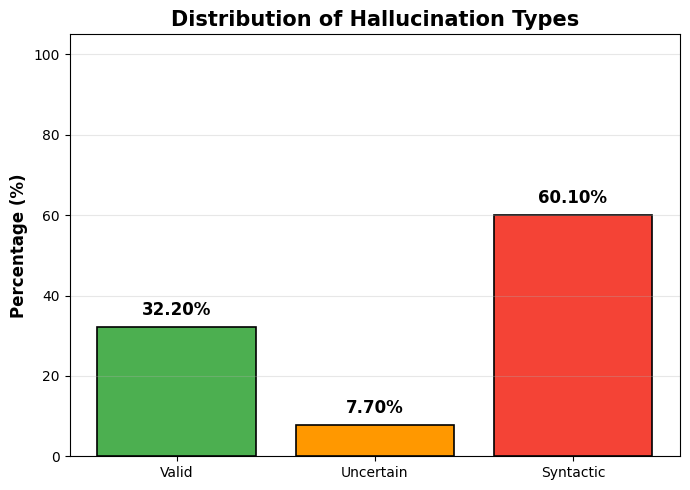

In [3]:
import matplotlib.pyplot as plt

# Données MANUELLES
labels = ["Valid", "Uncertain", "Syntactic"]
values = [32.2, 7.7, 60.1]

colors = ["#4CAF50", "#FF9800", "#f44336"]

plt.figure(figsize=(7,5))
bars = plt.bar(labels, values, color=colors, edgecolor="black", linewidth=1.2)

# Ajouter les pourcentages avec un espace plus grand au-dessus des barres
for bar, val in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 3,  # ← augmenter cet offset pour éloigner le texte
        f"{val:.2f}%",
        ha="center",
        fontsize=12,
        fontweight="bold"
    )

plt.ylabel("Percentage (%)", fontsize=12, fontweight="bold")
plt.title("Distribution of Hallucination Types", fontsize=15, fontweight="bold")
plt.ylim(0, 105)  # ← augmenter la limite pour que le texte tienne
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()
